In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
FILE_PATH = './data/sonnets.txt'
NUM_BATCHES = 16
LSTM_UNITS = 128
EMBEDDING_DIM = 100

In [4]:
# Read the data
with open(FILE_PATH) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


In [5]:
def fit_vectorizer(corpus):
    """
    Instantiates the vectorizer class on the corpus
    
    Args:
        corpus (list): List with the sentences.
    
    Returns:
        (tf.keras.layers.TextVectorization): an instance of the TextVectorization class containing the word-index dictionary,
        adapted to the corpus sentences.
    """    

    tf.keras.utils.set_random_seed(65) 

    

    # Define the object
    vectorizer = tf.keras.layers.TextVectorization()
    
    # Adapt it to the corpus
    vectorizer.adapt(corpus)

    
    
    return vectorizer

In [6]:
vectorizer = fit_vectorizer(corpus)
total_words = len(vectorizer.get_vocabulary())
print(f"Total number of words in corpus (including the out of vocabulary): {total_words}")

Total number of words in corpus (including the out of vocabulary): 3189


In [7]:
print(f"Passing a string directly: {vectorizer('This is a test string').__repr__()}")
print(f"Passing a list of strings: {vectorizer(['This is a test string'])}")

Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  29,   14,   18,    1, 1679], dtype=int64)>
Passing a list of strings: [[  29   14   18    1 1679]]


In [8]:
def n_gram_seqs(corpus, vectorizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        vectorizer (tf.keras.layers.TextVectorization): an instance of the TextVectorization class adapted in the corpus
    
    Returns:
        (list of tf.int64 tensors): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    
    for line in corpus:
        sequence = vectorizer(line)
        for i in range(1,len(sequence)):
            n_gram = sequence[:i+1]
            input_sequences.append(n_gram)
    
    
    
    return input_sequences

In [9]:
first_example_sequence = n_gram_seqs([corpus[0]], vectorizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 35, 489], dtype=int64)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  35,  489, 1259], dtype=int64)>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  35,  489, 1259,  164], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230], dtype=int64)>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230,  582], dtype=int64)>]

In [10]:
#bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], vectorizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  9, 935], dtype=int64)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  9, 935, 143], dtype=int64)>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  9, 935, 143, 369], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  9, 935, 143, 369, 101], dtype=int64)>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171], dtype=int64)>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171, 207], dtype=int64)>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([17, 23], dtype=int64)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17, 23,  3], dtype=int64)>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  17,   23,    3, 1006], dtype=int64)>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64], dtype=int64)>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31], dtype=int64)>,
 <tf.Tensor: shape

In [11]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, vectorizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15355
maximum length of sequences is: 11


In [12]:
def pad_seqs(input_sequences, max_sequence_len):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        (np.array of int32): tokenized sequences padded to the same length
    """
    
    

    padded_sequences = tf.keras.utils.pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre')

    
    
    return padded_sequences

In [13]:
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[   0,    0,    0,    0,   35,  489],
       [   0,    0,    0,   35,  489, 1259],
       [   0,    0,   35,  489, 1259,  164],
       [   0,   35,  489, 1259,  164,  230],
       [  35,  489, 1259,  164,  230,  582]])

In [14]:
#next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,    9,  935],
       [   0,    0,    0,    0,    0,    9,  935,  143],
       [   0,    0,    0,    0,    9,  935,  143,  369],
       [   0,    0,    0,    9,  935,  143,  369,  101],
       [   0,    0,    9,  935,  143,  369,  101,  171],
       [   0,    9,  935,  143,  369,  101,  171,  207],
       [   0,    0,    0,    0,    0,    0,   17,   23],
       [   0,    0,    0,    0,    0,   17,   23,    3],
       [   0,    0,    0,    0,   17,   23,    3, 1006],
       [   0,    0,    0,   17,   23,    3, 1006,   64],
       [   0,    0,   17,   23,    3, 1006,   64,   31],
       [   0,   17,   23,    3, 1006,   64,   31,   51],
       [  17,   23,    3, 1006,   64,   31,   51,  803],
       [   0,    0,    0,    0,    0,    0,   27,  315],
       [   0,    0,    0,    0,    0,   27,  315,  745],
       [   0,    0,    0,    0,   27,  315,  745,  101],
       [   0,    0,    0,   27,  315,  745,  101,  209],
       [   0,    0,   27,  315,

In [15]:
#padding whole text/corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15355, 11)


In [16]:
def features_and_labels_dataset(input_sequences, total_words):
    """
    Generates features and labels from n-grams and returns a tensorflow dataset
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        (tf.data.Dataset): Dataset with elements in the form (sentence, label)
    """

    # Define the features an labels as discussed in the lectures
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]

    # One hot encode the labels
    one_hot_labels = tf.keras.utils.to_categorical(labels,num_classes=total_words)

    # Build the dataset with the features and one hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((features,one_hot_labels)) 

    # Batch de dataset with number of batches given by the global variable
    batched_dataset = dataset.batch(NUM_BATCHES)


    return batched_dataset

In [17]:
dataset_example = features_and_labels_dataset(first_padded_seq, total_words)

print("Example:\n")
for features, label in dataset_example.take(1):
    print(f"N grams:\n\n {features}\n")
    print(f"Label shape:\n\n {label.shape}")

Example:

N grams:

 [[   0    0    0    0   35]
 [   0    0    0   35  489]
 [   0    0   35  489 1259]
 [   0   35  489 1259  164]
 [  35  489 1259  164  230]]

Label shape:

 (5, 3189)


In [18]:
# Split the whole corpus
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)

print(f"Feature shape: {dataset.element_spec[0]}")
print(f"Label shape: {dataset.element_spec[1]}")

Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3189), dtype=tf.float64, name=None)


In [19]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
       (tf.keras Model): the text generator model
    """
    model = tf.keras.Sequential()


    model.add(tf.keras.layers.Input((max_sequence_len-1,)))
    model.add(tf.keras.layers.Embedding(total_words, EMBEDDING_DIM))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS)))
    model.add(tf.keras.layers.Dense(total_words,activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    ### END CODE HERE ###

    return model

In [20]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Check the parameter count 
def parameter_count(model):
    total_params_solution, train_params_solution = 2_000_000, 2_000_000
    total_params = model.count_params()
    num_trainable_params = sum(
        [w.shape.num_elements() for w in model.trainable_weights]
    )
    total_msg = f"\033[92mYour model has {total_params:,} total parameters and the reference is {total_params_solution:,}"
    train_msg = f"\033[92mYour model has {num_trainable_params:,} trainable parameters and the reference is {train_params_solution:,}"
    if total_params > total_params_solution:
        total_msg += f"\n\033[91mWarning! this exceeds the reference which is {total_params_solution:,}. If the kernel crashes while training, switch to a simpler architecture."
    else:
        total_msg += "\033[92m. You are good to go!"
    if num_trainable_params > train_params_solution:
        train_msg += f"\n\033[91mWarning! this exceeds the reference which is {train_params_solution:,}. If the kernel crashes while training, switch to a simpler architecture."
    else:
        train_msg += "\033[92m. You are good to go!"
    print(total_msg)
    print()
    print(train_msg)

In [21]:
parameter_count(model)

Your model has 1,372,969 total parameters and the reference is 2,000,000. You are good to go!

Your model has 1,372,969 trainable parameters and the reference is 2,000,000. You are good to go!


In [22]:
example_batch = dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (16, 3189)


In [23]:
history = model.fit(dataset, epochs=30, verbose=1) #training the model

Epoch 1/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0265 - loss: 7.0522
Epoch 2/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0327 - loss: 6.1392
Epoch 3/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0448 - loss: 5.7551
Epoch 4/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0534 - loss: 5.4222
Epoch 5/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0625 - loss: 5.2024
Epoch 6/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0703 - loss: 4.9496
Epoch 7/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0864 - loss: 4.7689
Epoch 8/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1090 - loss: 4.5277
Epoch 9/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1528 - loss: 4.2084
Epoch 10/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1819 - loss: 4.0248
Epoch 11/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2365 - loss: 3.6943
Epoch 12/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

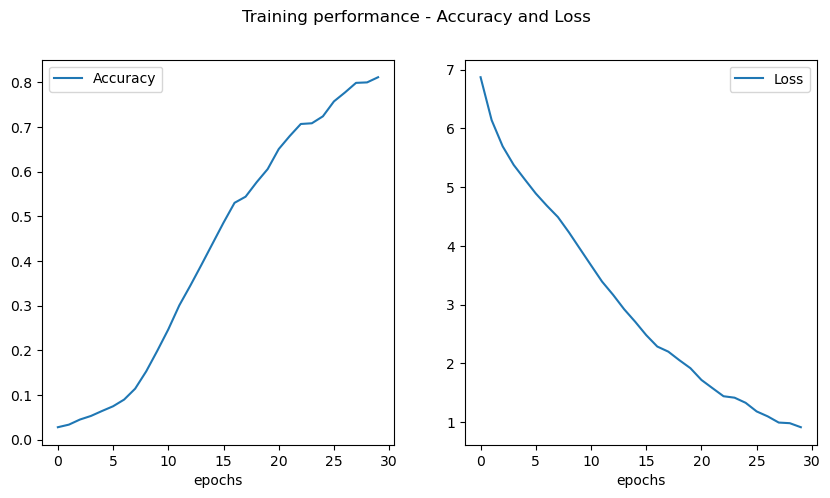

In [24]:
# Get training and validation accuracies
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training performance - Accuracy and Loss')

for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

In [25]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    # Convert the text into sequences
    token_list = vectorizer(seed_text)
    # Pad the sequences
    token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict([token_list], verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = vectorizer.get_vocabulary()[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

C:\Users\aksha\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1, 10))',)
  warnings.warn(msg)


Help me Obi Wan Kenobi, you're my only hope guest sweet story affords best dispraise slavery rudest truth told constancy constancy are more kind knife preposterously satire be kind steals state dead dead greater motley worst to brow away and art old time of your deeds see thee be youth and dwell to pitied be those will be none forsworn say none lovest well so long your state her eyes eyes to be insults night grey olives waning gilded light lovegod doom bending parallels tie constancy esteem prepare all ill dead will be dispraise merchandized fair bright child of mothers satire still bring lives sweet praises are perceived slavery
